# Plotting CO Ice for the Filament

In [2]:
print('test')

test


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions
from astropy.table import Table
import os

from spectral_cube import SpectralCube
import importlib as imp

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

In [4]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [5]:
from jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(co_map)
import extinction as ex

In [6]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


## Catalog

In [7]:
cat_use = make_cat_use()

In [8]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

cutout_filament = cm.Cutout(pos, w, l)
cutout_405 = cutout_filament.get_cutout_405()

In [9]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], cutout_405.wcs))
mask_red = (cat_filament.color('f182m', 'f212n') > 0.5) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = mask_red & (cat_filament.color('f410m', 'f466n') < 0)
cat_filament = JWSTCatalog(cat_filament.catalog[mask_red])

In [10]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
cat_f = JWSTCatalog(cat_use.table_region_mask(reg_f, cutout_405.wcs))
mask_red = (cat_f.color('f182m', 'f212n') > 0.5) | (np.isnan(np.array(cat_f.band('f182m'))) & np.isnan(np.array(cat_f.band('f187n')))) 
mask_red = mask_red & (cat_f.color('f410m', 'f466n') < 0)
cat_f = JWSTCatalog(cat_f.catalog[mask_red])

(0.0, 3.0)

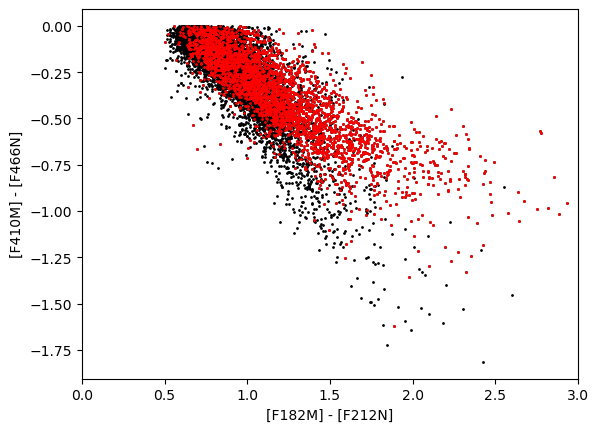

In [11]:
ax = plt.subplot(111)
cat_filament.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='k', s=1)
cat_f.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='r', s=1)
ax.set_xlim(0, 3)

## CO Ice

In [12]:
Av_182212 = cat_filament.get_Av('f182m', 'f212n', ext=CT06_MWLoc())
too_red = np.isnan(np.array(cat_filament.band('f182m'))) & ~np.isnan(np.array(cat_filament.band('f212n')))
cat_filament.catalog['N(CO)'] = co_map.get_co_column(cat_filament, Av_182212, ext=CT06_MWLoc(), consts_file='1_CO_(1)_12.5K_Baratta.txt')

In [13]:
co_col_map = co_map.make_co_column_map(cat_filament, cat_filament.catalog['N(CO)'], cutout_405.wcs, cutout_405.shape, fwhm=30, k=5)

Text(0, 0.5, 'N(CO) (cm$^{-2}$)')

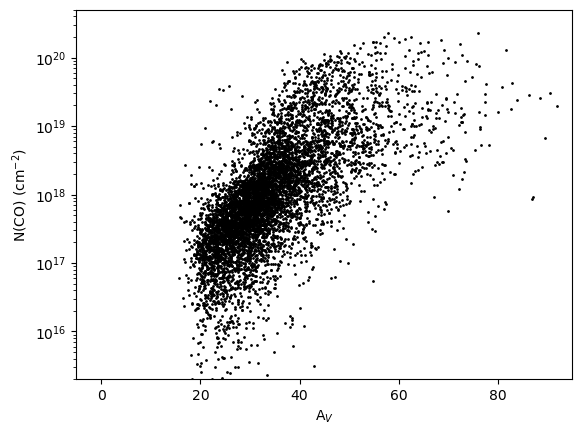

In [14]:
co_map.plot_Av_COice(Av_182212, cat_filament.catalog['N(CO)'], s=1, color='k')
plt.yscale('log')
plt.xlabel('A$_V$')
plt.ylabel('N(CO) (cm$^{-2}$)')

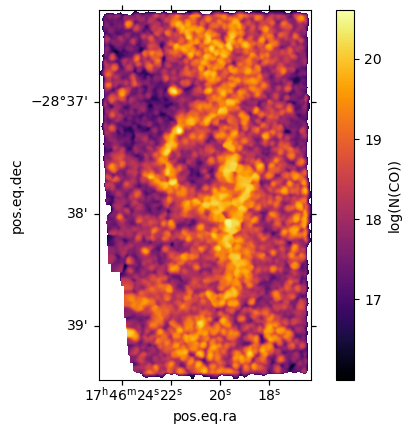

In [15]:
co_col_map[co_col_map < 1e16] = np.nan
ax = plt.subplot(projection=cutout_405.wcs)
im = ax.imshow(np.log10(co_col_map), origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, label='log(N(CO))')